## Deevio Coding Challenge | EDA and model training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imgaug as ia
import imgaug.augmenters as iaa
import pickle5 as pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.morphology import remove_small_objects
from skimage.io import imread
from skimage.transform import resize

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import backend as K
#check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Utilities

In [33]:
def plot_history(history):
    """plot model history"""
    plt.figure()
    plt.plot(history.history['val_accuracy'], 
             color='green', 
             label='Validation accuracy')
    plt.plot(history.history['accuracy'], 
             color='blue', 
             label='Training accuracy')
    plt.title('Training and validation accuracy across epochs')
    plt.legend()
    plt.figure()
    plt.plot(history.history['val_loss'], 
             color='green', 
             label='Validation loss')
    plt.plot(history.history['loss'], 
             color='blue', 
             label='Training loss')
    plt.title('Training and validation loss across epochs')
    plt.legend()

## EDA

In [4]:
#load image names
df_good = pd.read_csv('nailgun/good.txt', sep=" ", header=None)
df_good['good'] = 1
df_bad = pd.read_csv('nailgun/bad.txt', sep=" ", header=None)
df_bad['good'] = 0
df_label = pd.concat([df_good, df_bad])
df_label.reset_index(drop=True, inplace=True)
df_label.rename(columns={0: "ImageId"}, inplace=True)

In [5]:
df_label.head(3)

,ImageId,good
0,1522072665_good.jpeg,1
1,1522072726_good.jpeg,1
2,1522072743_good.jpeg,1


In [6]:
print("No. of good images:", df_good.shape[0])
print("No. of bad images:", df_bad.shape[0])

No. of good images: 99
No. of bad images: 99


__Althought the dataset is perfectly balanced, this size is generally considered to be too small for a convolutional neural network (CNN). However traditional machine learning is not as effective in extracting geometrically local information. Given the small size of the dataset, which implies that time will not be the critical path, a CNN is a reasonable approach. __

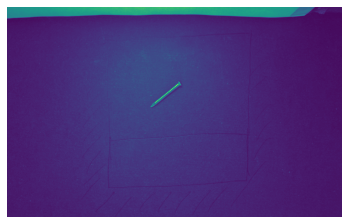

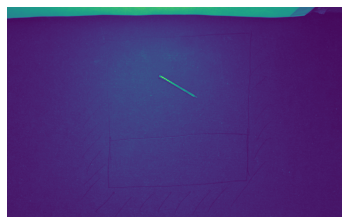

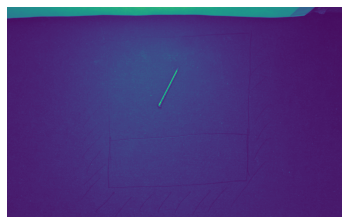

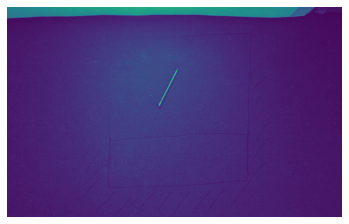

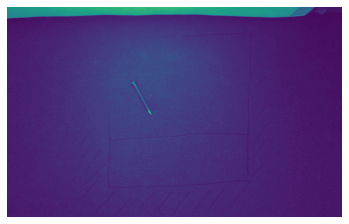

In [7]:
for i in range(5):
    img = imread("nailgun/good/"+df_good.iloc[i,0], as_gray=True)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

__The nails are placed within the drawn box. The images can be cropped to only include the box so that the images have a smaller size without losing any information.__

__The cropped image will be cropped with a tolerance, to a size that is slightly larger than the drawn bounding box, in case the worker accidentally placed the nail at the edge of the drawn box.__

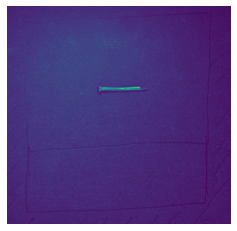

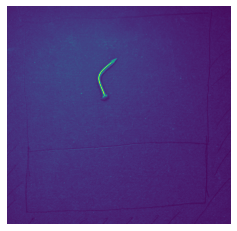

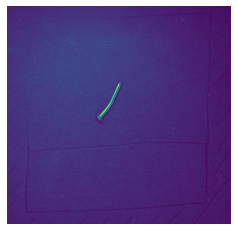

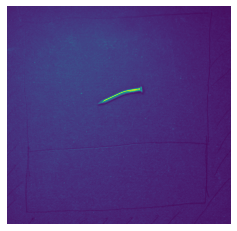

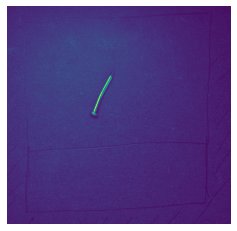

In [8]:
for i in range(5):
    img = imread("nailgun/bad/"+df_bad.iloc[i,0], as_gray=True)
    img = img[125:1100,500:1500]
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

__Image can be cropped even further to preserve even more information about the nail. The nail is usually the brightest object in the image. By calculating the average location of the brightest pixels, it is very likely the location is somewhere at the nail.__

__Image are filtered with a threshold to remove noise. The threshold is calculated per image to handle the different lighting of each image.__

__Small objects are removed to further remove noise.__

__Image is resized to 224x224 to fit into the pretrained neural net.__

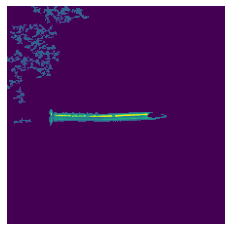

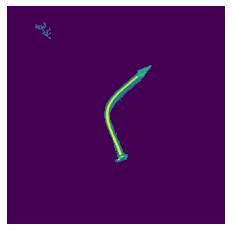

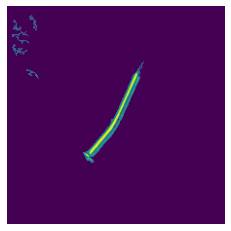

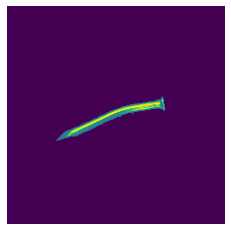

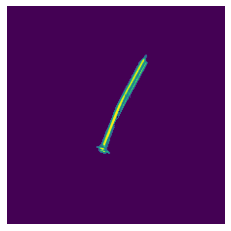

In [9]:
for i in range(5):
    img = imread("nailgun/bad/"+df_bad.iloc[i,0], as_gray=True)
    img = img[125:1100,500:1500]
    #find the average location of the top 20 brightest pixels
    sort_image = np.dstack(np.unravel_index(np.argsort(img[:,:].ravel()), (975, 1000)))
    sort_x_avg = int(np.around(np.average(sort_image[:,-20:-1,0])))
    sort_y_avg = int(np.around(np.average(sort_image[:,-20:-1,1])))

    if sort_x_avg < 200:
        sort_x_avg = 200
    elif sort_x_avg + 200 > 975:
        sort_x_avg = 975-200
    if sort_y_avg < 200:
        sort_y_avg = 200
    elif sort_y_avg + 200> 1000:
        sort_y_avg = 1000-200

    img = img[sort_x_avg-200:sort_x_avg+200,sort_y_avg-200:sort_y_avg+200]
    #resize image, note that skimage also normalizes the image
    img = resize(img, (224, 224))
    
    #add image threshold and remove small objects
    threshold = np.average(img) + np.std(img)*0.75
    pred_temp = img.copy() 
    cnd = (img[:] >= threshold)
    pred_temp[cnd] = 1
    cnd = (img[:] < threshold)
    pred_temp[cnd] = 0
    pred_temp=pred_temp.astype('bool')
    pred_temp = remove_small_objects(pred_temp, 30, connectivity=2, in_place=True)
    img = np.multiply(img, pred_temp)
    img = np.array(img, dtype=np.float32)

    plt.figure()
    plt.axis('off')
    plt.imshow(img)

__CNN is rotational invariant. Unlike recognizing normal objects, these nails can appear in all possible rotations. Image augmentation is very important to allow the CNN to generalize its learning. Flipping and rotation will be applied, zooming is unnecessary as the factory cameras are usually at the same height above the nails.__  

## Data Generator

This data generator is copied from my final project with some modifications. A Keras ImageDataGenerator might be a simpler choice but has less versatility. A customer data generator is chosen because it has already been written and it can easily be modifified.

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
              image_h=224, image_w=224, preprocess=None, shuffle=False):
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_h = image_h
        self.image_w = image_w
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """number of batches per epoch"""
        return int(np.floor(len(self.list_ids)) / self.batch_size)

    def on_epoch_end(self):
        """update ended after each epoch"""
        self.indexes = np.arange(len(self.list_ids))
        #shuffle images for training more evenly
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp):
        """process X and y to be returned to __getitem__"""
        X = np.empty((self.batch_size, self.image_h, self.image_w, 3))
        y = np.empty(self.batch_size)
        for i,image_id in enumerate(list_ids_temp):
            
            #modify path depending on 
            if self.labels[self.labels['ImageId']==image_id]['good'].iloc[0] == 0:
                image_path = os.path.join(self.image_dir, "bad")
            else:
                image_path = os.path.join(self.image_dir, "good")
            image_path = os.path.join(image_path, image_id)
            image = imread(image_path, as_gray=True)
            image = image[125:1100,500:1500]
            #find the location of nail by finding the 
            #average location of the top 20 brightest pixels
            sort_image = np.dstack(np.unravel_index(np.argsort(image[:,:].ravel()), (975, 1000)))
            sort_x_avg = int(np.around(np.average(sort_image[:,-20:-1,0])))
            sort_y_avg = int(np.around(np.average(sort_image[:,-20:-1,1])))
            if sort_x_avg < 200:
                sort_x_avg = 200
            elif sort_x_avg + 200 > 975:
                sort_x_avg = 975-200
            if sort_y_avg < 200:
                sort_y_avg = 200
            elif sort_y_avg + 200> 1000:
                sort_y_avg = 1000-200
            image = image[sort_x_avg-200:sort_x_avg+200,sort_y_avg-200:sort_y_avg+200]
            #resize image, not that skimage also normalizes the image
            image = resize(image, (self.image_w, self.image_h))
            
            #image threshold different for each image 
            #due to different lighting throughout the day
            threshold = np.average(image) + np.std(image)*0.75
            pred_temp = image.copy() 
            cnd = (image[:] >= threshold)
            pred_temp[cnd] = 1
            cnd = (image[:] < threshold)
            pred_temp[cnd] = 0
            pred_temp=pred_temp.astype('bool')
            pred_temp = remove_small_objects(pred_temp, 40, connectivity=2, in_place=True)
            image = np.multiply(image, pred_temp)
            image = np.array(image, dtype=np.float32)

            #image augmentation
            seq = iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Affine(
                    rotate=(0, 360),
                )
            ], random_order=True) # apply augmenters in random order
            
            image = seq(images=image)
            image = np.expand_dims(image, 2)
            X[i, ] = image * np.ones((1, 1, 3))
            y[i] = self.labels[self.labels['ImageId']==image_id]['good'].iloc[0].astype(np.float32)
        y.reshape((self.batch_size,1))
        return X,y

    def __getitem__(self, index):
        """ takes an index and returns the corresponding X and y"""
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_ids_temp = [self.list_ids[k] for k in indexes]
        X,y = self.__data_generation(list_ids_temp)
        return X,y  

## Model instantisiation

The train test split is stratified and shuffled for the following reasons:
1. A balanced dataset to improve model accuracy.
2. Simple comparison against the simplest baseline model -> coin toss -> 50% accuracy. If the model has an accuracy higher than 50% then it is performing better than a random guess. 

In [11]:
#Configurations
IMG_W = 224
IMG_H = 224
BATCH_SIZE = 20
EPOCHS = 30
VAL_SIZE = 0.2

In [12]:
X = df_label['ImageId'].values

In [13]:
X_train, X_test, _, _ = train_test_split(X, 
                                         df_label['good'], 
                                         test_size=VAL_SIZE, 
                                         random_state=42,
                                         shuffle=True, 
                                         stratify=df_label['good'])
#preprocess set to none as the data will be normalized anyway in the data generator
params = {'image_h': IMG_H,
          'image_w': IMG_W,
          'image_dir': "nailgun/",
          'batch_size': BATCH_SIZE,
          'preprocess': None,
          'shuffle': True}

In [14]:
training_generator = DataGenerator(X_train, df_label, **params)
validation_generator = DataGenerator(X_test, df_label, **params)

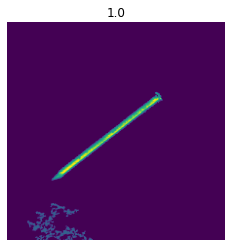

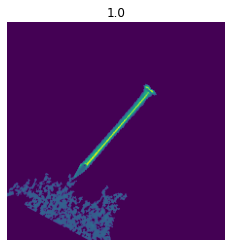

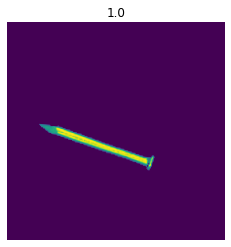

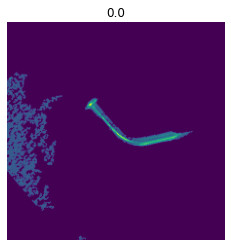

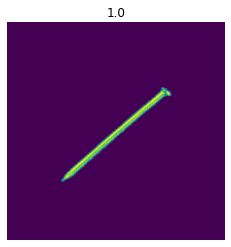

In [15]:
#check generators
x, y = training_generator.__getitem__(0)
for i in range(5):
    plt.figure()
    plt.imshow(x[i][:,:,0])
    plt.axis('off')
    plt.title(y[i]) #good = 1, bad = 0

In [16]:
#load pretrained ResNet50v2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

m = ResNet50V2()
# connect to input and output of existing model
act = Dense(1, activation='sigmoid')(m.layers[-1].output)
m2 = Model(inputs=m.input, outputs=[act])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
#freeze added layers for 10 epochs of warm-up
for layer in m2.layers:
    if layer.name in ['dense']:
        layer.trainable = True
    else:
        layer.trainable = False
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
history_00 = m2.fit_generator(generator=training_generator, 
                          validation_data=validation_generator, 
                          epochs=10, 
                          verbose=1, 
                          workers=8)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/10
7/7 [==============================] - 15s 2s/step - loss: 0.6933 - accuracy: 0.5143 - val_loss: 0.6985 - val_accuracy: 0.3500
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.6932 - accuracy: 0.5214 - val_loss: 0.6973 - val_accuracy: 0.3750
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.6931 - accuracy: 0.5429 - val_loss: 0.6978 - val_accuracy: 0.3750
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.6925 - accuracy: 0.6071 - val_loss: 0.6985 - val_accuracy: 0.3750
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.6930 - accuracy: 0.5286 - val_loss: 0.6972 - val_accuracy: 0.4250
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.6917 - accuracy: 0.6357 - val_loss: 0.6949 - val_accuracy: 0.4000
Epoch 7

## Model training

In [19]:
#unfreeze 2nd last layer
m2.save('200306_model_warmup.h5')
with open("200306_model_warmup_history.pkl", 'wb') as f:
    pickle.dump(history_00.history, f)  
for layer in m2.layers:
    if layer.name in ['dense', 'probs']:
        layer.trainable = True
    else:
        layer.trainable = False
m2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
# checkpoint to save all epochs
filepath = "checkpoint/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=False,
                             mode='max')
callbacks_list = [checkpoint]

In [21]:
history_01 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 1s - loss: 0.6898 - accuracy: 0.6917
Epoch 00001: saving model to checkpoint/weights-improvement-01-0.62.h5
7/7 [==============================] - 15s 2s/step - loss: 0.6893 - accuracy: 0.7214 - val_loss: 0.6875 - val_accuracy: 0.6250
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6802 - accuracy: 0.7500
Epoch 00002: saving model to checkpoint/weights-improvement-02-0.70.h5
7/7 [==============================] - 10s 1s/step - loss: 0.6803 - accuracy: 0.7429 - val_loss: 0.6785 - val_accuracy: 0.7000
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.6798 - accuracy: 0.7083
Epoch 00003: saving model to checkpoint/weights-improvement-03-0.75.h5
7/7 [==============================] - 10s 1s/step - loss: 0.6794 - accuracy: 0.7071 - val_loss: 0.6727 - val_accuracy: 0.7500
Epoch 4/50
6/7 [========================

7/7 [==============================] - 10s 1s/step - loss: 0.6098 - accuracy: 0.7786 - val_loss: 0.6001 - val_accuracy: 0.8000
Epoch 29/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5900 - accuracy: 0.8500
Epoch 00029: saving model to checkpoint/weights-improvement-29-0.77.h5
7/7 [==============================] - 10s 1s/step - loss: 0.5902 - accuracy: 0.8429 - val_loss: 0.6151 - val_accuracy: 0.7750
Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5848 - accuracy: 0.8333
Epoch 00030: saving model to checkpoint/weights-improvement-30-0.88.h5
7/7 [==============================] - 10s 1s/step - loss: 0.5847 - accuracy: 0.8357 - val_loss: 0.5695 - val_accuracy: 0.8750
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5659 - accuracy: 0.9000
Epoch 00031: saving model to checkpoint/weights-improvement-31-0.90.h5
7/7 [==============================] - 11s 2s/step - loss: 0.5697 - accuracy: 0.8857 - val_loss: 0.5572 - val_accuracy: 0.9000


In [22]:
with open("200306_model_01.pkl", 'wb') as f:
    pickle.dump(history_01.history, f)  

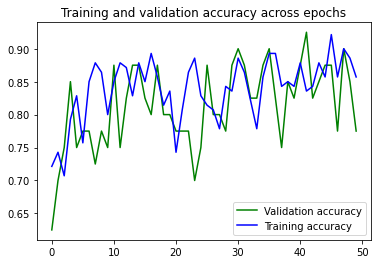

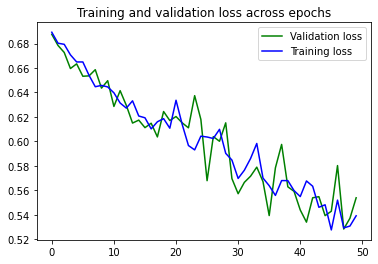

In [34]:
plot_history(history_01)

__Loss of both validation and training is still dropping->can be further optimized.__

In [24]:
history_02 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5477 - accuracy: 0.8333
Epoch 00001: saving model to checkpoint/weights-improvement-01-0.95.h5
7/7 [==============================] - 10s 1s/step - loss: 0.5491 - accuracy: 0.8286 - val_loss: 0.4944 - val_accuracy: 0.9500
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5460 - accuracy: 0.8583
Epoch 00002: saving model to checkpoint/weights-improvement-02-0.98.h5
7/7 [==============================] - 10s 1s/step - loss: 0.5486 - accuracy: 0.8500 - val_loss: 0.4773 - val_accuracy: 0.9750
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.5589 - accuracy: 0.7917
Epoch 00003: saving model to checkpoint/weights-improvement-03-0.90.h5
7/7 [==============================] - 10s 1s/step - loss: 0.5543 - accuracy: 0.8000 - val_loss: 0.5155 - val_accuracy: 0.9000
Epoch 4/50
6/7 [========================

7/7 [==============================] - 11s 2s/step - loss: 0.5042 - accuracy: 0.8571 - val_loss: 0.5117 - val_accuracy: 0.8250
Epoch 29/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4760 - accuracy: 0.9167
Epoch 00029: saving model to checkpoint/weights-improvement-29-0.95.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4823 - accuracy: 0.9000 - val_loss: 0.4502 - val_accuracy: 0.9500
Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4836 - accuracy: 0.8917
Epoch 00030: saving model to checkpoint/weights-improvement-30-0.82.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4874 - accuracy: 0.8857 - val_loss: 0.5082 - val_accuracy: 0.8250
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4966 - accuracy: 0.8667
Epoch 00031: saving model to checkpoint/weights-improvement-31-0.95.h5
7/7 [==============================] - 11s 2s/step - loss: 0.4900 - accuracy: 0.8786 - val_loss: 0.4371 - val_accuracy: 0.9500


In [25]:
with open("200306_model_02.pkl", 'wb') as f:
    pickle.dump(history_02.history, f)  

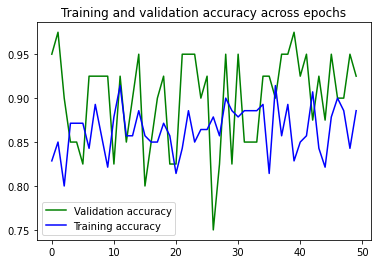

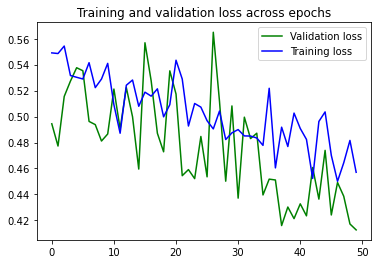

In [37]:
plot_history(history_02)

__Loss of both validation and training is still dropping->can be further optimized.__

In [27]:
history_03 = m2.fit_generator(generator=training_generator, 
                             validation_data=validation_generator, 
                             epochs=50, 
                             verbose=1, 
                             workers=8,
                             callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 7 steps, validate for 2 steps
Epoch 1/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4531 - accuracy: 0.8917
Epoch 00001: saving model to checkpoint/weights-improvement-01-0.95.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4521 - accuracy: 0.8929 - val_loss: 0.4079 - val_accuracy: 0.9500
Epoch 2/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4637 - accuracy: 0.8667
Epoch 00002: saving model to checkpoint/weights-improvement-02-0.90.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4554 - accuracy: 0.8786 - val_loss: 0.4265 - val_accuracy: 0.9000
Epoch 3/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4941 - accuracy: 0.8500
Epoch 00003: saving model to checkpoint/weights-improvement-03-0.93.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4838 - accuracy: 0.8643 - val_loss: 0.4029 - val_accuracy: 0.9250
Epoch 4/50
6/7 [========================

7/7 [==============================] - 10s 1s/step - loss: 0.4354 - accuracy: 0.8714 - val_loss: 0.3614 - val_accuracy: 0.9750
Epoch 29/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4254 - accuracy: 0.8917
Epoch 00029: saving model to checkpoint/weights-improvement-29-0.95.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4292 - accuracy: 0.8857 - val_loss: 0.3715 - val_accuracy: 0.9500
Epoch 30/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4538 - accuracy: 0.8583
Epoch 00030: saving model to checkpoint/weights-improvement-30-0.93.h5
7/7 [==============================] - 11s 2s/step - loss: 0.4571 - accuracy: 0.8571 - val_loss: 0.4046 - val_accuracy: 0.9250
Epoch 31/50
6/7 [========================>.....] - ETA: 0s - loss: 0.4571 - accuracy: 0.8750
Epoch 00031: saving model to checkpoint/weights-improvement-31-0.93.h5
7/7 [==============================] - 10s 1s/step - loss: 0.4531 - accuracy: 0.8714 - val_loss: 0.3957 - val_accuracy: 0.9250


In [28]:
with open("200306_model_03.pkl", 'wb') as f:
    pickle.dump(history_03.history, f)  

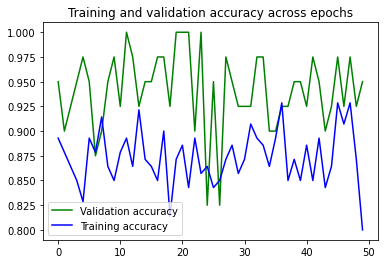

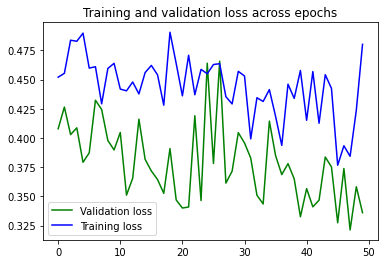

In [36]:
plot_history(history_03)

__The loss is still decreasing but the accuracy is not changing significantly. Training further is not necessary. The best model that has the best bias-variance balance is at the 48th epoch where the training accuracy = 0.9286 and the validation accuracy = 0.975.__
